# Filter POS to improve word vectors

## Filter
* **AUX** 		Auxiliary verb	 _wurde, wird, hast, sind_
* **PUNCT** 	Punctuation		_., ,, :, (, ),_
* **DET (?)** 	Determiner		_des, der,  das, ein_
* **ADP** 		Apposition		_für, nördlich, in, um_
* **X** 		Other
* **NUM** 	Numbers		_007, 0.2, 09_
* **CONJ**	Coord.  onj.    _und, als_

## Also try
* **PART** 	Participle		_ein, zu, statt_
* **SCONJ**     Subord. conj.        _um, wenn_
* **ADV**		Adverb			_damit, nun, auch_
* **PRON (?)**	Pronoun			_er, sich, sie_ 


In [1]:
cd ..

/Users/williraschkowski/dev/goethe


In [64]:
import spacy

nlp = spacy.load('de')

In [206]:
import re
import os
import nltk
import itertools as it

class Corpus:
    def __init__(self, path, n=None):
        self.path = path
        
    def __iter__(self, tokens=True):
        with open(self.path) as lines:
            yield from (nltk.word_tokenize(sent.strip()) if tokens else sent.strip() for sent in lines)


class POSCorpus(Corpus):
    def __init__(self, path):
        self.path = path
        self.filter = {'AUX', 'PUNCT', 'DET', 'ADP', 'X', 'NUM', 'CONJ'}
        self._sents = None
        
    def __iter__(self):
        for sent in self.sents:
            yield [str(w) for w in sent if w.pos_ not in self.filter]
    
    @property
    def sents(self):
        if not self._sents:
            self._sents = list(nlp.pipe(super().__iter__(tokens=False), parse=False))
        return self._sents

In [300]:
corpus = Corpus('data/leipzig/deu_wikipedia_2014_3M.txt')
pos_corpus = POSCorpus('data/leipzig/deu_wikipedia_2014_3M.txt')

In [475]:
filter_pos = {'AUX',
              'PUNCT', 
              'DET', 
              'ADP', 
              'X',
              'NUM',
              'CONJ'}

docs = [d for d in nlp.pipe(it.islice(corpus.__iter__(tokens=False), 150)) if len(d.text) < 80 and len(d.text) > 20]

for i, doc in enumerate(docs):
    try:
        tokens = [(str(w).rjust(len(w.pos_)), w.pos_.rjust(len(w))) for w in doc]
        words, tags = list(zip(*tokens))
    except ValueError:
        continue
    print(' '.join(words))
    print(' '.join(tags))
    print()
    try:
        tokens = [(str(w).rjust(len(w.pos_)), w.pos_.rjust(len(w))) for w in doc if w.pos_ not in filter_pos]
        words, tags = list(zip(*tokens))
    except ValueError:
        continue
    print(' '.join(words))
    print(' '.join(tags))
    print('\n---------------------------------------------\n')

007 James  Bond greift  ein     .
NUM PROPN PROPN   VERB PART PUNCT

James  Bond greift  ein
PROPN PROPN   VERB PART

---------------------------------------------

0,2   g des Krauts sind für Mäuse  und Frösche tödlich     .
NUM ADP DET   NOUN  AUX ADP  NOUN CONJ    NOUN     ADJ PUNCT

Krauts Mäuse Frösche tödlich
  NOUN  NOUN    NOUN     ADJ

---------------------------------------------

07.28 * Ultraphon     A 531     (    mx     .  10 984     ) Küsse mich     ,  wenn   du mich lieb hast     .
  NUM X     PROPN PROPN NUM PUNCT PROPN PUNCT NUM NUM PUNCT  NOUN PRON PUNCT SCONJ PRON PRON  ADJ  AUX PUNCT

Ultraphon     A    mx Küsse mich  wenn   du mich lieb
    PROPN PROPN PROPN  NOUN PRON SCONJ PRON PRON  ADJ

---------------------------------------------

 09     : Nördlich der Trave liegt Kücknitz     , das alte Industrieviertel von Lübeck     .
NUM PUNCT      ADP DET  NOUN  VERB    PROPN PUNCT DET  ADJ             NOUN ADP  PROPN PUNCT

Trave liegt Kücknitz alte Industrieviertel L

## Model training

In [ ]:
import gensim

In [301]:
%%time
model = gensim.models.word2vec.Word2Vec(corpus)

CPU times: user 1h 3min 12s, sys: 13 s, total: 1h 3min 25s
Wall time: 55min 53s


In [303]:
model.save('models/3M')
posmodel.save('models/3M_pos')

In [302]:
%%time
posmodel = gensim.models.word2vec.Word2Vec(pos_corpus)

CPU times: user 28min 37s, sys: 18min 25s, total: 47min 3s
Wall time: 54min 10s


In [340]:
acc = model2.accuracy('evaluation/bestmatch-questions.txt', case_insensitive=False)
posacc = posmodel.accuracy('evaluation/bestmatch-questions.txt', case_insensitive=False)

In [337]:
def acc_summary(section, correct, incorrect):
    return {
        'name': section,
        'questions': len(correct) + len(incorrect),
        'accuracy': round(len(correct) / (len(correct) + len(incorrect)), 2)
    }

results = [acc_summary(**s) for s in acc]
posresults = [acc_summary(**s) for s in acc]

In [476]:
results

[{'accuracy': 0.0, 'name': 'Land-Währung', 'questions': 3},
 {'accuracy': 0.0, 'name': 'Hauptstad-Land', 'questions': 28},
 {'accuracy': 0.0, 'name': 'Land-Kontinent', 'questions': 28},
 {'accuracy': 0.0, 'name': 'Land-Sprache', 'questions': 1},
 {'accuracy': 0.0, 'name': 'Geschlecht', 'questions': 28},
 {'accuracy': 0.0, 'name': 'Gegenteil', 'questions': 115},
 {'accuracy': 0.0, 'name': 'total', 'questions': 203}]

In [382]:
from collections import defaultdict
from pprint import pprint

def sections(path):
    sections = defaultdict(list)
    with open(path) as f:
        for l in f:
            l = l.strip()
            if l.startswith(':'):
                sec = l[2:]
            else:
                sections[sec].append(l.split(' '))
    return sections

def accuracy(model, path, topn=10):
    secs = sections(path)
    results = {}
    for sname, questions in secs.items():
        secsims = []
        for man, king, woman, queen in questions: 
            sims = model.most_similar(positive=[king, woman], negative=[man], topn=10)
            sims = [sim for word, sim in sims if word == queen]
            secsims.append(sims[0] if sims else 0)
        results[sname] = sum(secsims) / len(secsims)
    return results

In [415]:
acc = accuracy(model, 'evaluation/bestmatch-questions.txt')
accdf = pd.DataFrame.from_records(list(acc.items()), columns=['Category', 'Accuracy'])
accdf['Model'] = 'Normal'

In [423]:
posacc = accuracy(posmodel, 'evaluation/bestmatch-questions.txt')
posaccdf = pd.DataFrame.from_records(list(posacc.items()), columns=['Category', 'Accuracy'])
posaccdf['Model'] = 'W/O POS'

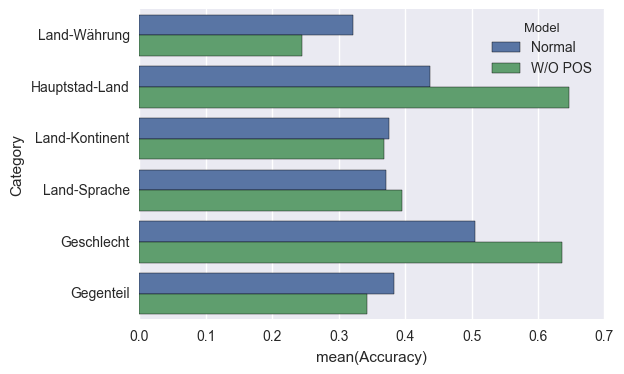

In [422]:
%matplotlib inline
import seaborn as sns
# ax = sns.barplot(x="day", y="total_bill", hue="sex", data=tips)
ax = sns.barplot(y="Category", x="Accuracy", hue="Model", data=accdf.append(posaccdf), ci=None)